#<a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science (CDS)</a>
#Test <a href=http://www.ramp.studio/events/iris_test>RAMP on iris</a> 

<i> Adapted for Chalab by Isabelle Guyon from original code of Balázs Kégl (LAL/CNRS)</i>

ALL INFORMATION, SOFTWARE, DOCUMENTATION, AND DATA ARE PROVIDED "AS-IS". The CDS, CHALEARN, AND/OR OTHER ORGANIZERS OR CODE AUTHORS DISCLAIM ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY PARTICULAR PURPOSE, AND THE WARRANTY OF NON-INFRIGEMENT OF ANY THIRD PARTY'S INTELLECTUAL PROPERTY RIGHTS. IN NO EVENT SHALL AUTHORS AND ORGANIZERS BE LIABLE FOR ANY SPECIAL, 
INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF SOFTWARE, DOCUMENTS, MATERIALS, PUBLICATIONS, OR INFORMATION MADE AVAILABLE FOR THE CHALLENGE. 

## Introduction

Iris is a small standard multi-class classification data set from the <a href="http://archive.ics.uci.edu/ml/datasets/Iris">UCI Machine Learning Repository</a>, formatted in the AutoML format.

In [1]:
codedir = 'sample_code/'                        # Change this to the directory where you put the code
from sys import path; path.append(codedir)
%matplotlib inline
import seaborn as sns; sns.set()

## Fetch the data and load it

In [2]:
datadir = 'public_data/'                        # Change this to the directory where you put the input data
dataname = 'iris'
basename = datadir  + dataname
!ls $basename*

public_data/iris_feat.name   public_data/iris_train.data
public_data/iris_label.name  public_data/iris_train.solution
public_data/iris_test.data   public_data/iris_valid.data


In [3]:
import data_io
reload(data_io)
data = data_io.read_as_df(basename)                          # The data are loaded as a Pandas Data Frame
#data.to_csv(basename + '_train.csv', index=False)           # This allows saving the data in csv format

Reading public_data/iris_train from AutoML format
Number of examples = 105
Number of features = 4
Number of classes = 3


In [4]:
data.head()

,sepal_length,sepal_width,petal_length,petal_width,target
0,4.4,3.0,1.3,0.2,versicolor
1,4.7,3.2,1.6,0.2,versicolor
2,6.1,2.6,5.6,1.4,virginica
3,6.4,3.1,5.5,1.8,virginica
4,5.8,4.0,1.2,0.2,versicolor


In [5]:
data.describe() 

,sepal_length,sepal_width,petal_length,petal_width
count,105.000000,105.000000,105.000000,105.000000
mean,5.774286,3.063810,3.596190,1.130476
std,0.795423,0.472132,1.781201,0.763484
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.500000,0.300000
50%,5.700000,3.000000,4.200000,1.300000
75%,6.400000,3.400000,5.100000,1.800000
max,7.700000,4.400000,6.700000,2.500000


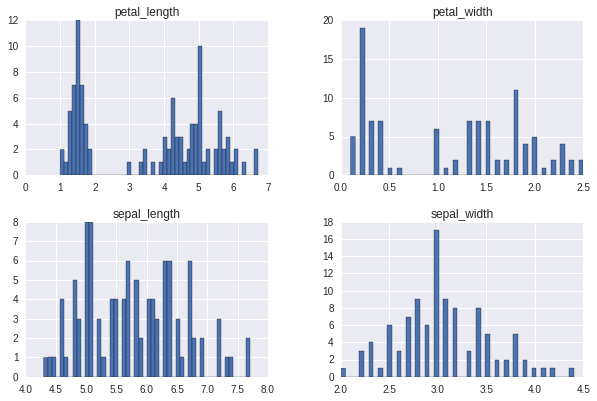

In [6]:
data.hist(figsize=(10, 10), bins=50, layout=(3, 2));

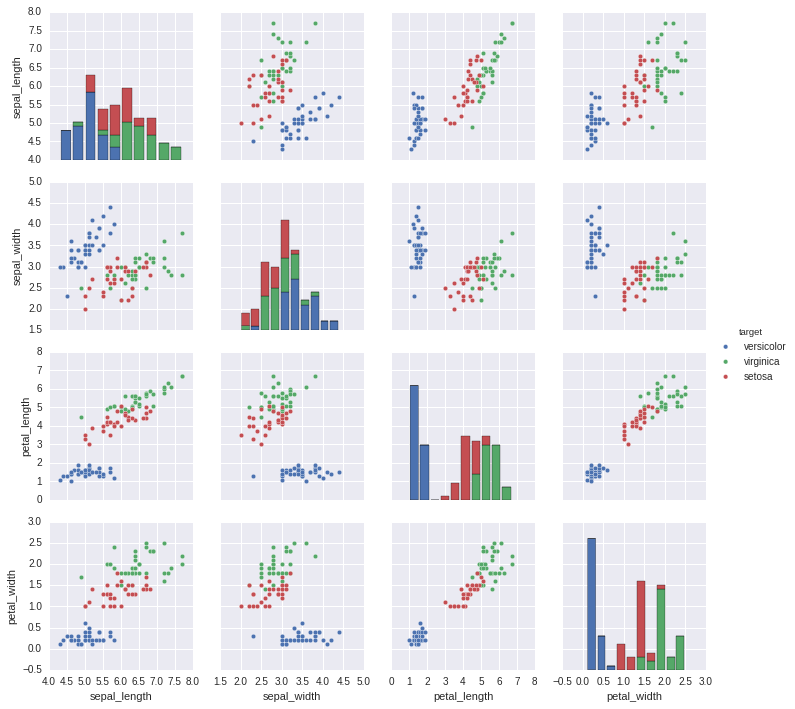

In [7]:
sns.pairplot(data, hue="target")

## Building a predictive model

Data matrices for training and making predictions.

In [8]:
X_train = data.drop('target', axis=1).values            # This is the data matrix you already loaded (training data)
y_train = data['target'].values                         # These are the target values encoded as categorical variables
print 'Dimensions X_train=', X_train.shape, 'y_train=', y_train.shape
X_valid = data_io.read_as_df(basename, 'valid').values
X_test = data_io.read_as_df(basename, 'test').values

Dimensions X_train= (105, 4) y_train= (105,)
Reading public_data/iris_valid from AutoML format
Number of examples = 15
Number of features = 4
Reading public_data/iris_test from AutoML format
Number of examples = 30
Number of features = 4


The initial classifier in your starting kit (in the sample_code directory).

In [9]:
import classifier
reload(classifier)                               # If you make changes to your code you have to reload it
from classifier import Classifier
Classifier??

Train, run, and save your classifier and your predictions. If you saved a trained model and/or prediction results, the evaluation script will look for those and use those in priority [(1) use saved predictions; (2) if no predictions, use saved model, do not retrain, just test; (3) if neither, train and test model from scratch]. Compute the predictions with predict_proba, this is more versatile.

In [10]:
result_dir = 'res/'
outname = result_dir + dataname
clf = Classifier()
clf.fit(X_train, y_train)
Y_valid = clf.predict_proba(X_valid) 
Y_test = clf.predict_proba(X_train) 
clf.save(outname)
#clf.load(outname) # Uncomment to check reloading works
data_io.write(outname + '_valid.predict', Y_valid)
data_io.write(outname + '_test.predict', Y_test)
!ls $outname*

res/iris_model.pickle  res/iris_test.predict  res/iris_valid.predict


Compute the training accuracy.

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# Directly predicts the (categorical) class labels
y_predict = clf.predict(X_train)                   
print 'Training accuracy = ', accuracy_score(y_train, y_predict)
class_labels = clf.get_classes()     
print 'Class labels=', class_labels
print 'Confusion matrix [known in lines, predicted in columns]=\n',confusion_matrix(y_train, y_predict, class_labels)

Training accuracy =  1.0
Class labels= ['setosa' 'versicolor' 'virginica']
Confusion matrix [known in lines, predicted in columns]=
[[30  0  0]
 [ 0 40  0]
 [ 0  0 35]]


Compute cross-validation accuracy. This is usually worse than the training accuracy. Notice that we internally split the training data into training and validation set (this is because we do NOT have the labels of X_valid and X_test).

In [12]:
from sklearn.cross_validation import StratifiedShuffleSplit
# This is just an example of 2-fold cross-validation
skf = StratifiedShuffleSplit(y_train, n_iter=2, test_size=0.5, random_state=61)
i=0
for idx_t, idx_v in skf:
    i=i+1
    Xtr = X_train[idx_t]
    Ytr = y_train[idx_t]
    Xva = X_train[idx_v]
    Yva = y_train[idx_v]
    clf = Classifier()
    clf.fit(Xtr, Ytr)
    Y_predict = clf.predict(Xva)
    print 'Fold', i, 'validation accuracy = ', accuracy_score(Y_predict, Yva)

Fold 1 validation accuracy =  0.88679245283
Fold 2 validation accuracy =  0.905660377358


ADVANCED: Sklearn does not have multi-class metrics, this shows how libscore metrics work.

In [13]:
import libscores
 
# To evaluate results with multi-class metrics, the targets must be encoded as one vs. the rest
Y_train, C = libscores.onehot(y_train)                                   
print 'Dimensions Y_train=', Y_train.shape, 'Class labels=', C
assert((class_labels==C).all()) # Just to make sure the labels of the classifier are in the right order
# Note: if all went well, you should recover public_data/iris_train.solution
# You had it all along, but to show you some nice plots we loaded the data as a data frame so we lost it!

from libscores import bac_metric 
from libscores import pac_metric 
# Predicts probabilities, a matrix patnum x classnum 
# As solution, you must use Y_train, not y_train
y_predict_proba = clf.predict_proba(X_train)      
print 'Training balanced accuracy = ', bac_metric(Y_train, y_predict_proba, task='multiclass.classification')
print 'Training probabilistic accuracy = ', pac_metric(Y_train, y_predict_proba, task='multiclass.classification')

Dimensions Y_train= (105, 3) Class labels= ['setosa' 'versicolor' 'virginica']
Training balanced accuracy =  0.916666666667
Training probabilistic accuracy =  0.211533239034


## Unit testing

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>classifier.py</code> in the <code>sample_code/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission.  The program looks for saved results and saved models in the subdirectory <code>res/</code>. If it finds them, it will use them: (1) If results are found, then are copied to the output directory; (2) If no results but a trained model is found, it is reloaded and no training occurs; (3) If nothing is found a fresh model is trained and tested.

In [14]:
outdir = '../outputs'         # If you use result_dir as output directory, your submission will include your results

In [15]:
!python run.py $datadir $outdir

Using input_dir: public_data/
Using output_dir: /home/aymeric.debuisson/Documents/Python/outputs
************************************************************************
****** Attempting to copy files (from res/) for RESULT submission ******
************************************************************************
[+] Iris copied
[+] Results copied to output directory, no model trained/tested
========= Zipping this directory to prepare for submit ==============
See: ../sample_submission_17-02-10-17-32.zip
[+] Done
[+] Overall time spent  3.94 sec ::  Overall time budget  0.00 sec


## Making your submission

The test program <code>run.py</code> prepares your <code>zip</code> file, ready to go. You find it in the directory above where you ran your program. For large datasets, we recommend that <b><span style="color:red">you do NOT bundle the data with your submission</span></b>. The data directory is passed as an argument to run.py, and it is already there on the test server.